In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from lang_sam import LangSAM
import torch
import os
import cv2
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity

/Users/akhilralla/Desktop/billing-server/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Configs
# path to directory to dump embeddings
run_id = 'run_1'
# number of frames to extract in a minute
frame_rate = 1
#maxID : number of products to process starting: 1001
max_id = 1001

In [3]:
def get_device_type() -> str:
    if torch.backends.mps.is_available():
        return "cpu"
    elif torch.cuda.is_available():
        return "cuda"
    else:
        # logging.warning("No GPU found, using CPU instead")
        return "cpu"

In [4]:
# Load the model and processor
embeddingModel = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch16").half().to(get_device_type())
embeddingProcessor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [5]:
class ObjectDetector:
    def __init__(self):
        self.model = LangSAM(sam_type="sam2.1_hiera_tiny", gdino_type="tiny")
    
    def predict(self, image_pil, text_prompt):
        results = self.model.predict([image_pil], [text_prompt])
        return results
    
    def plot_results(self, image_pil, results, text_prompt):
        
        # Convert the mask to a numpy array
        mask = results[0]['masks'][0]

        # Plot the image
        plt.figure(figsize=(10, 10))
        plt.imshow(image_pil)

        # Plot the bounding box
        box = results[0]['boxes'][0]
        plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='red', facecolor='none', linewidth=2))

        # Plot the mask
        plt.imshow(np.ma.masked_where(mask == 0, mask), alpha=0.5, cmap='jet')

        plt.title(f"Prediction for: {text_prompt}")
        plt.axis('off')
        plt.show()

    # given an image and results, hide the mask on the image by making the values zero within the mask
    def hide_mask(self, image_pil, results):
        mask = results[0]['masks'][0]
        image_np = np.array(image_pil)
        image_np[mask == 1] = 0
        return Image.fromarray(image_np)

    def crop_image(self, image_pil, results):
        box = results[0]['boxes'][0]
        cropped_image = image_pil.crop((box[0], box[1], box[2], box[3]))
        return cropped_image
    
    def predict_and_crop_image(self, image_pil, text_prompt):
        results = self.predict(image_pil, text_prompt)
        cropped_image = self.crop_image(image_pil, results)
        return cropped_image

    def show_image(self, image_pil):
        plt.imshow(image_pil)
        plt.axis('off')
        plt.show()

    def resize(self, image_pil, long_side):
        width, height = image_pil.size
        if width > height:
            new_width = long_side
            new_height = int(long_side * height / width)
        else:
            new_height = long_side
            new_width = int(long_side * width / height)
        return image_pil.resize((new_width, new_height))
object_detector = ObjectDetector()

In [6]:
def extract_frames(video_path, frame_rate):
    video_capture = cv2.VideoCapture(video_path)
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    interval = int(fps / frame_rate)
    frame_number = 0
    frames = []
    while True:
        success, frame = video_capture.read()
        if not success:
            break
        if frame_number % interval == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)

        frame_number += 1
    video_capture.release()
    return frames

In [7]:
def toFilter(path, maxNumber= 1999):
    try:
        number = path.split('_')[0]
        return int(number) <= maxNumber
    except:
        return False

In [8]:
embeddings = {}
video_frame_map = {}
video_frame_map_cropped = {}
video_frame_map_masked = {}
def load_embeddings():
    path_to_videos = "./sourceDataVideos/"
    videos = os.listdir(path_to_videos)
    # videos = videos[:2]
    print(videos)
    count = 0
    for video in videos:
        if(not toFilter(video, max_id)):
            continue
        print("--------------------- Processing video: ", count, video)
        count += 1
        video_path = os.path.join(path_to_videos, video)
        frames = extract_frames(video_path, frame_rate)
        print("Number of frames: ", len(frames))
        id = video.split("_")[0]
        frame_number = 0
        for frame in frames:
            print("Processing frame: ", frame_number)
            image = Image.fromarray(frame)
            resultsMasked = object_detector.predict(image, "hand, no background, no object")
            masked_image = object_detector.hide_mask(image, resultsMasked)
            cropped_image = object_detector.predict_and_crop_image(masked_image, "object, no hand, no background")
            inputs = embeddingProcessor(images=cropped_image, return_tensors="pt", padding=True)
            with torch.no_grad():
                features = embeddingModel(**inputs)
                features.image_embeds = features.image_embeds
            embeddings[id + "_" + str(frame_number)] = features
            video_frame_map[id + "_" + str(frame_number)] = image
            video_frame_map_cropped[id + "_" + str(frame_number)] = cropped_image
            video_frame_map_masked[id + "_" + str(frame_number)] = masked_image
            frame_number += 1
load_embeddings()

['1022_Lux-Soap_30.mp4', '1034_Tide-Surf_45.mp4', '1009_Wheel-Soap_10.mp4', '1046_Parachute-Oil_104.mp4', '1051_CorrianderPowder-Spices_5.mp4', '1027_Rin-Surf_10.mp4', '1054_Jeera-Spices_25.mp4', '1069_SmallRava1kg-Grains_40.mp4', '1082_GajrajRice500g-Grains_28.mp4', '1048_Maggi-Noodles_5.mp4', '1017_KrackJack-Biscuit_5.mp4', '1001_Dove-Soap_35.mp4', '1018_Glucose-Biscuit_10.mp4', '1016_Oreo-Biscuit_10.mp4', '1052_SambarPowder-Spices_10.mp4', '1005_Santoor-Soap_40.mp4', '1059_TurmericPowder-Spices_5.mp4', '.DS_Store', '1007_XXX-Soap_10.mp4', '1032_Ariel-Surf_10.mp4', '1066_GroundNut1kg-Grains_140.mp4', '1062_ChickenMasala-Spices_5.mp4', '1049_MustardSeeds-Spices_5.mp4', '1076_GroundNut500g-Grains_70.mp4', '1047_Yippee-Noodles_14.mp4', '1039_Wheel-Surf_38.mp4', '1015_AllRounder-Biscuit_5.mp4', '1058_Efkay-Tea_10.mp4', '1008_Diamond-Soap_10.mp4', '1055_GodavariGhee-Milk_10.mp4', '1050_Kumkum-Temple_5.mp4', '1079_SmallRava500g-Grains_20.mp4', '1040_XXX-Surf_38.mp4', '1014_ButterDelite-Bis

/Users/akhilralla/Desktop/billing-server/myenv/lib/python3.11/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Predicted 1 masks
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks
Processing frame:  1
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks
Processing frame:  2
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks
Processing frame:  3
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks
Processing frame:  4
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks
Processing frame:  5
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks
Processing frame:  6
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks
Processing frame:  7
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks


In [9]:
products = {}
def load_products():
    # Read the CSV file
    df = pd.read_csv('output.csv')

    # Create the dictionary
    for _, row in df.iterrows():
        product_id = str(row['id'])
        products[product_id] = {
            'id': product_id,
            'nickname': row['nickname'],
            'price': row['price']
        }
load_products()

In [10]:
images = {}
image_map = {}
image_cropped_map = {}
def load_images():
    path_to_images = "./sourceDataImages/"
    imageDirs = os.listdir(path_to_images)
    print(imageDirs)
    imageDirCount = 0
    for imageDir in imageDirs:
        try:
            if(not toFilter(imageDir, max_id)):
                continue
            print("Processing imageDir: ", imageDirCount)
            imagePaths = os.listdir(os.path.join(path_to_images, imageDir))
            count = 0
            print("Processing imageDir: ", imageDir)
            for imagePath in imagePaths:
                image = Image.open(os.path.join(path_to_images, imageDir, imagePath))
                cropped_image = object_detector.predict_and_crop_image(image, "object, not hand, not background")
                inputs = embeddingProcessor(images=cropped_image, return_tensors="pt", padding=True)
                with torch.no_grad():
                    features = embeddingModel(**inputs)
                    features.image_embeds = features.image_embeds
                images[imageDir + "_" + str(count) ] = features
                image_map[imageDir + "_" + str(count) ] = image
                image_cropped_map[imageDir + "_" + str(count) ] = cropped_image
                count += 1
        except:
            print("Error processing imageDir: ", imageDir)
        imageDirCount += 1
        
load_images()

['1069', '1056', '1051', '1058', '1067', '1060', '1034', '1033', '1005', '1002', '1061', '1059', '1066', '1050', '1068', '1057', '1003', '1032', '1035', '.DS_Store', '1028', '1017', '1010', '1019', '1026', '1021', '1081', '1075', '1072', '1044', '1043', '1020', '1018', '1027', '1011', '1029', '1016', '1042', '1045', '1073', '1074', '1080', '1030', '1037', '1008', '1001', '1006', '1039', '1052', '1055', '1063', '1064', '1007', '1038', '1036', '1009', '1031', '1065', '1062', '1054', '1053', '1071', '1082', '1076', '1049', '1040', '1047', '1078', '1013', '1014', '1022', '1025', '1046', '1079', '1041', '1077', '1083', '1048', '1070', '1024', '1023', '1015', '1012']
Processing imageDir:  0
Processing imageDir:  1001
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks
Predicting 1 masks


Unused or unrecognized kwargs: padding.


Predicted 1 masks


In [11]:
def searchProduct(imageFeatures):
    # Process the input image
    query_embedding = imageFeatures.image_embeds.detach().cpu().numpy()


    # Calculate cosine similarities
    similarities = []
    for id, embedding in embeddings.items():
        embedding = embedding.image_embeds.detach().cpu().numpy()
        similarity = cosine_similarity(query_embedding, embedding)
        similarities.append((id, similarity))

    top_five = sorted(similarities, key=lambda item: item[1], reverse=True)[:5]
    # filtered_results = [(id, sim) for id, sim in top_five if sim > 0.8]
    # Get the product details for the top five items
    filtered_products = []
    for closest_id, maxSimilarity in top_five:
        # closest_id = closest_id.split("_")[0]
        product_details = products[closest_id.split("_")[0]]
        filtered_products.append((product_details, closest_id, maxSimilarity))

    return filtered_products

In [12]:
match = 0
for id, feature in images.items():
    product_id = id.split("_")[0]
    query_product = products[product_id]
    results = searchProduct(feature)
    print("Query: ", query_product, results)
    
    if query_product['id'] == results[0][0]['id']:
    # or query_product['id'] == results[1][0]['id'] or query_product['id'] == results[2][0]['id'] or query_product['id'] == results[3][0]['id'] or query_product['id'] == results[4][0]['id']:
        match += 1
    
    print(query_product['nickname'], "-------", results[0][0]['nickname'])
print("Match: ", match, "Total: ", len(images))

Query:  {'id': '1001', 'nickname': 'Dove Soap', 'price': 35} [({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_0', array([[0.78889262]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_1', array([[0.76654029]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_2', array([[0.68649518]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_3', array([[0.67028728]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_4', array([[0.5990365]]))]
Dove Soap ------- Dove Soap
Query:  {'id': '1001', 'nickname': 'Dove Soap', 'price': 35} [({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_2', array([[0.79959033]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_7', array([[0.76428224]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_6', array([[0.76011873]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_3', array([[0.7348814]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price':

Query:  {'id': '1001', 'nickname': 'Dove Soap', 'price': 35} [({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_0', array([[0.78889262]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_1', array([[0.76654029]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_2', array([[0.68649518]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_3', array([[0.67028728]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_4', array([[0.5990365]]))]


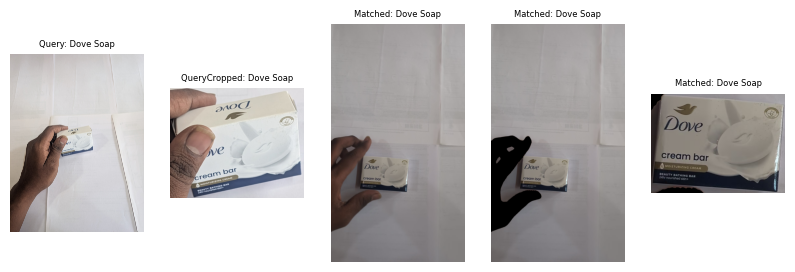

Dove Soap ------- Dove Soap
Query:  {'id': '1001', 'nickname': 'Dove Soap', 'price': 35} [({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_2', array([[0.79959033]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_7', array([[0.76428224]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_6', array([[0.76011873]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_3', array([[0.7348814]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_5', array([[0.67767013]]))]


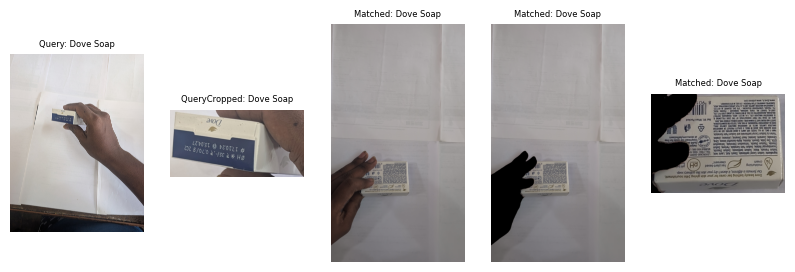

Dove Soap ------- Dove Soap
Query:  {'id': '1001', 'nickname': 'Dove Soap', 'price': 35} [({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_3', array([[0.78751129]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_2', array([[0.7645858]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_1', array([[0.71691848]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_6', array([[0.70587373]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_0', array([[0.66038092]]))]


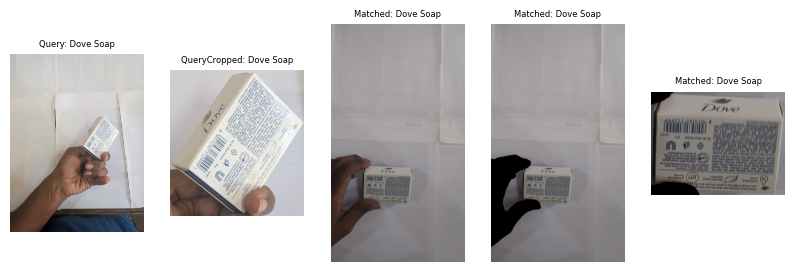

Dove Soap ------- Dove Soap
Query:  {'id': '1001', 'nickname': 'Dove Soap', 'price': 35} [({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_0', array([[0.881774]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_1', array([[0.81413665]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_3', array([[0.75073476]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_2', array([[0.71219988]])), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_4', array([[0.68827928]]))]


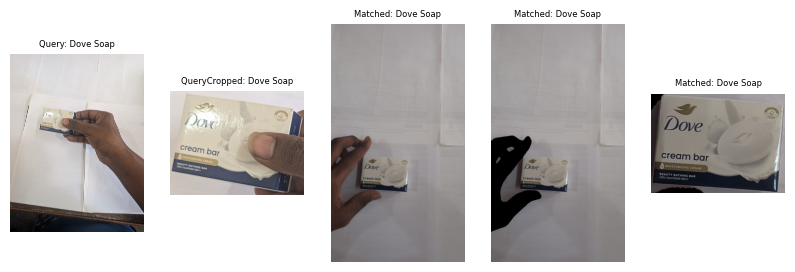

Dove Soap ------- Dove Soap
Match:  4 Total:  4


In [13]:

match = 0
for id, feature in images.items():
    product_id = id.split("_")[0]
    query_product = products[product_id]
    results = searchProduct(feature)
    print("Query: ", query_product, results)
    
    
        
    # Plot images in a 2x1 matrix
    fig, axes = plt.subplots(1, 5, figsize=(10, 5))

    # Plot the query image
    query_image = image_map[id]
    axes[0].imshow(query_image)
    axes[0].set_title(f"Query: {query_product['nickname']}", fontsize=6)
    axes[0].axis('off')

    query_crop_image = image_cropped_map[id]
    axes[1].imshow(query_crop_image)
    axes[1].set_title(f"QueryCropped: {query_product['nickname']}", fontsize=6)
    axes[1].axis('off')

    # Plot the matched video frame
    if product_id == results[0][0]['id']:
        matchString = "Matched"
    else:
        matchString = "Not Matched"
    matched_id = results[0][1]
    matched_frame = video_frame_map[matched_id]
    axes[2].imshow(matched_frame)
    axes[2].set_title(f"{matchString}: {results[0][0]['nickname']}", fontsize=6)
    axes[2].axis('off')

    axes[3].imshow(video_frame_map_masked[matched_id])
    axes[3].set_title(f"{matchString}: {results[0][0]['nickname']}", fontsize=6)
    axes[3].axis('off')

    axes[4].imshow(video_frame_map_cropped[matched_id])
    axes[4].set_title(f"{matchString}: {results[0][0]['nickname']}", fontsize=6)
    axes[4].axis('off')


    plt.show()
    if product_id == results[0][0]['id']:
        match += 1
    
    print(query_product['nickname'], "-------", results[0][0]['nickname'])
print("Match: ", match, "Total: ", len(images))

In [14]:
variables_to_dump = {
    'embeddings': embeddings,
    'video_frame_map': video_frame_map,
    'video_frame_map_cropped': video_frame_map_cropped,
    'video_frame_map_masked': video_frame_map_masked,
    'products': products,
    'images': images,
    'image_map': image_map,
    'image_cropped_map': image_cropped_map
}

if os.path.exists(run_id):
    print("Directory already exists, skipping saving variables")
    exit()

if not os.path.exists(run_id):
    os.makedirs(run_id)

for name, variable in variables_to_dump.items():
    torch.save(variable, os.path.join(run_id, name + ".pt"))